In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import random

In [7]:
import tensorflow as tf
tf.__version__

'2.17.1'

## Dataset Import

In [8]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [9]:
X_train_norm = (x_train)/255
X_test_norm = (x_test)/255

In [10]:
from sklearn.utils import shuffle
X_train_norm, y_train = shuffle(X_train_norm, y_train)

In [11]:
from sklearn.model_selection import train_test_split
X_train_norm_sp, X_val_sp, y_train_sp, y_val_sp = train_test_split(
    X_train_norm, y_train, test_size=0.2, shuffle=True, stratify=y_train
)

## Task 1 - Custom Model

we know ResNet is very good for image classification, particularly on ImageNet. While the Microsoft's Resnet50 model has too many parameters,
we can implement a small version of a residual network

In [9]:
from tensorflow.keras import layers, models

def residual_block(x, filters, strides=1):
    shortcut = x

    x = layers.Conv2D(filters, (3, 3), strides=strides, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)

    if strides > 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), strides=strides, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def create_small_resnet(input_shape=(32, 32, 3), num_classes=10):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)

    x = residual_block(x, 16)
    x = residual_block(x, 16, strides=2)
    x = residual_block(x, 32)
    x = residual_block(x, 32, strides=2)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [18]:
model = create_small_resnet()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 32, 32, 16)     │            448 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 32, 32, 16)     │             64 │ conv2d_12[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 32, 32, 16)     │          2,320 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_14    │ (None, 32, 32, 16)     │             64 │ conv2d_13[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 32, 32, 16)     │          2,320 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 32, 32, 16)     │             64 │ conv2d_14[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 32, 32, 16)     │              0 │ batch_normalization_1… │
│                           │                        │                │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, 32, 32, 16)     │              0 │ add_4[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 16, 16, 16)     │          2,320 │ activation_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 16, 16, 16)     │             64 │ conv2d_15[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 16, 16, 16)     │          2,320 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 16, 16, 16)     │            272 │ activation_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_17    │ (None, 16, 16, 16)     │             64 │ conv2d_16[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 16, 16, 16)     │             64 │ conv2d_17[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_5 (Add)          

 Total params: 48,154 (188.10 KB)

 Trainable params: 47,450 (185.35 KB)

 Non-trainable params: 704 (2.75 KB)

as we can see this architecture have 47,450 trainable parameters, meeting the size criterion

In [12]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from tensorflow.keras.callbacks import EarlyStopping

Using this function that was created in the previous assignment

In [2]:
def eval_architecture(model, history):
    # evaluate overall accuracy of the model
    score = model.evaluate(X_test_norm, y_test)
    print('Test Accuracy: {}'.format(score[1]))

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(accuracy))

    # plot accuracy over epochs
    plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # plot loss over epochs
    plt.plot(epochs, loss, 'ro', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()

    predict_x=model.predict(X_test_norm)
    predicted_classes = np.argmax(predict_x,axis=1)
    y_true = y_test

    # create confusion matrix
    cm = confusion_matrix(y_true, predicted_classes)
    plt.figure(figsize = (10, 10))
    sns.heatmap(cm, annot = True)

    # compute metrics per class
    precisions, recall, f1_score, _ = precision_recall_fscore_support(y_true, predicted_classes)
    model_metrics_df = pd.DataFrame({
        'Class': list(range(len(np.unique(y_true)))),
        'Precision': precisions,
        'Recall': recall,
        'F1-Score': f1_score
    })


    print(model_metrics_df)

In [23]:
def train_architecture(model, batch_size, epochs, early_stopping=True, es_patience=5):
    if early_stopping:
        early_stopping_callback = EarlyStopping(monitor='val_loss', patience=es_patience)

    # train model
    history = model.fit(
                X_train_norm_sp,
                y_train_sp,
                batch_size = batch_size,
                epochs = epochs,
                verbose = 1,
                shuffle = True,
                callbacks=[early_stopping_callback] if early_stopping else None,
                validation_data = (X_val_sp, y_val_sp)
            )
    return history


In [26]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [27]:
history = train_architecture(model, batch_size=32, epochs=20, es_patience=3)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.2859 - loss: 2.0265 - val_accuracy: 0.4433 - val_loss: 1.5176
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.4959 - loss: 1.3808 - val_accuracy: 0.4813 - val_loss: 1.4058
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5797 - loss: 1.1897 - val_accuracy: 0.6151 - val_loss: 1.0599
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6226 - loss: 1.0783 - val_accuracy: 0.6254 - val_loss: 1.0503
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.6539 - loss: 0.9912 - val_accuracy: 0.6328 - val_loss: 1.0322
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6670 - loss: 0.9473 - val_accuracy: 0.6550 - val_loss: 0.9628
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6897 - loss: 0.8909 - val_accuracy: 0.6691 - val_loss: 0.9378
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7062 - loss: 0.853

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7397 - loss: 0.7838
Test Accuracy: 0.7361999750137329
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
   Class  Precision  Recall  F1-Score
0      0   0.770325   0.758  0.764113
1      1   0.901604   0.843  0.871318
2      2   0.800659   0.486  0.604854
3      3   0.508853   0.661  0.575033
4      4   0.602465   0.782  0.680592
5      5   0.619872   0.680  0.648546
6      6   0.847722   0.707  0.770992
7      7   0.833523   0.731  0.778903
8      8   0.891747   0.832  0.860838
9      9   0.776408   0.882  0.825843


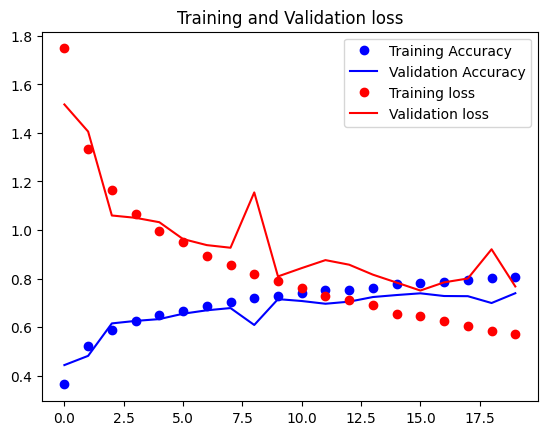

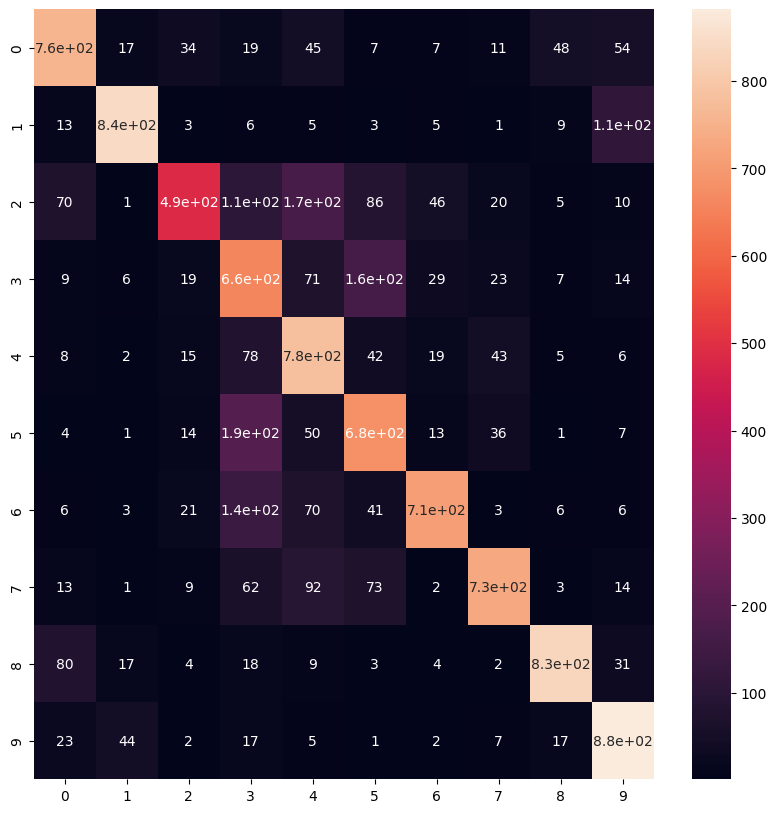

In [30]:
eval_architecture(model, history)

The model obtain an accuracy of 0.736 on the test set, which is very good

## Task 2 - Transfer Learning from Imagenet

In [13]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16
# from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

In [54]:
base_model = VGG16(weights = 'imagenet', include_top = False)

In [55]:
print(base_model.summary())

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

None


In [18]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, AveragePooling2D, Conv2D

In [57]:
model = Sequential()

# freeze and add the 10 first layers of VGG16
for layer in base_model.layers[:10]:
    layer.trainable = False
    model.add(layer)

model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,777,290 (6.78 MB)

 Trainable params: 41,802 (163.29 KB)

 Non-trainable params: 1,735,488 (6.62 MB)

Here we have 41,802 trainable params, so we are under the limit of 70,000

In [58]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [59]:
history = train_architecture(model, batch_size=32, epochs=20, es_patience=5)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.4400 - loss: 1.7225 - val_accuracy: 0.6133 - val_loss: 1.0997
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6186 - loss: 1.0773 - val_accuracy: 0.6502 - val_loss: 0.9938
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6489 - loss: 0.9885 - val_accuracy: 0.6545 - val_loss: 0.9908
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6761 - loss: 0.9266 - val_accuracy: 0.6530 - val_loss: 0.9917
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.6797 - loss: 0.9032 - val_accuracy: 0.6894 - val_loss: 0.9001
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6945 - loss: 0.8563 - val_accuracy: 0.6857 - val_loss: 0.8950
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6987 - loss: 0.8541 - val_accuracy: 0.6743 - val_loss: 0.9386
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7057 - loss: 0.8304 -

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7068 - loss: 0.8250
Test Accuracy: 0.7052000164985657
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
   Class  Precision  Recall  F1-Score
0      0   0.768131   0.752  0.759980
1      1   0.886308   0.725  0.797580
2      2   0.682486   0.604  0.640849
3      3   0.563084   0.482  0.519397
4      4   0.686616   0.631  0.657634
5      5   0.491396   0.771  0.600234
6      6   0.776618   0.744  0.759959
7      7   0.821387   0.699  0.755267
8      8   0.808867   0.821  0.814888
9      9   0.715652   0.823  0.765581


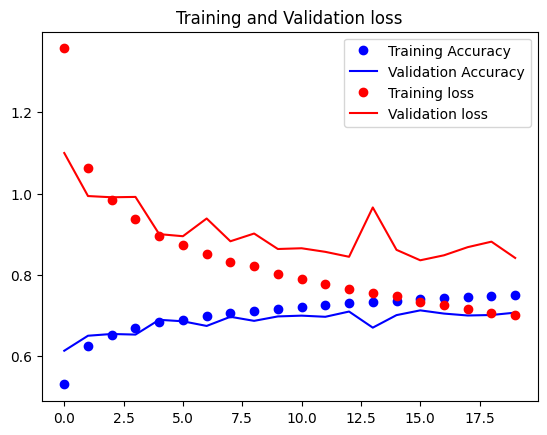

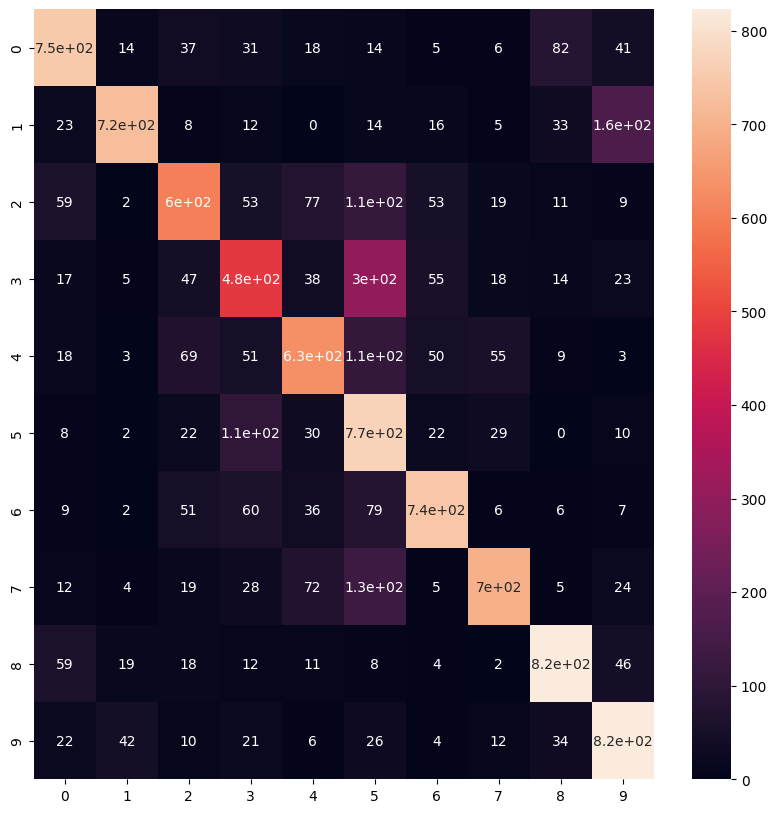

In [60]:
eval_architecture(model, history)

This model archieves a good accuracy of 0.705 on the test set

## Task 3 - Transfer Learning from MNIST


In [15]:
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input

In [20]:
mnist_model = load_model("mnist_model_weights.h5")

mnist_model.summary()

for layer in mnist_model.layers[1:4]:
    layer.trainable = False

# Create a new model using the first 4 layers of the pretrained MNIST model
mnist_pretrained_model = Sequential(
    [
        Input(shape=(32, 32, 3)), # Input dimensions of the images
        Conv2D(32, kernel_size=(3, 3), activation="relu"), # CNN to map features from 3 to 32 channels
        *mnist_model.layers[1:4], # Add the first 4 layers from the pretrained MNIST model

        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),

        Dense(10, activation="softmax"), # Output layer for 10 classes
    ]
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │          16,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,828 (136.05 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

The number of trainable parameter for this model is 34,826, which is below the 70,000 limit

In [21]:
mnist_pretrained_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
history = train_architecture(mnist_pretrained_model, batch_size=32, epochs=200, es_patience=10)

Epoch 1/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.2272 - loss: 2.0341 - val_accuracy: 0.3299 - val_loss: 1.7737
Epoch 2/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3425 - loss: 1.7431 - val_accuracy: 0.3655 - val_loss: 1.7021
Epoch 3/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.3681 - loss: 1.6850 - val_accuracy: 0.3645 - val_loss: 1.6796
Epoch 4/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.3847 - loss: 1.6546 - val_accuracy: 0.3838 - val_loss: 1.6519
Epoch 5/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3986 - loss: 1.6125 - val_accuracy: 0.4070 - val_loss: 1.5869
Epoch 6/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4154 - loss: 1.5751 - val_accuracy: 0.4218 - val_loss: 1.5659
Epoch 7/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4242 - loss: 1.5598 - val_accuracy: 0.4134 - val_loss: 1.5700
Epoch 8/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4336 - loss: 

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5293 - loss: 1.3116
Test Accuracy: 0.5266000032424927
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
   Class  Precision  Recall  F1-Score
0      0   0.578189   0.562  0.569980
1      1   0.614851   0.621  0.617910
2      2   0.457672   0.346  0.394077
3      3   0.364121   0.410  0.385701
4      4   0.444653   0.474  0.458858
5      5   0.504274   0.413  0.454096
6      6   0.508283   0.675  0.579897
7      7   0.533835   0.568  0.550388
8      8   0.663959   0.654  0.658942
9      9   0.621281   0.543  0.579509


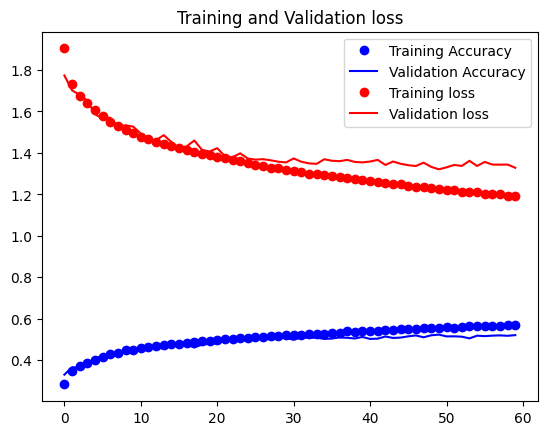

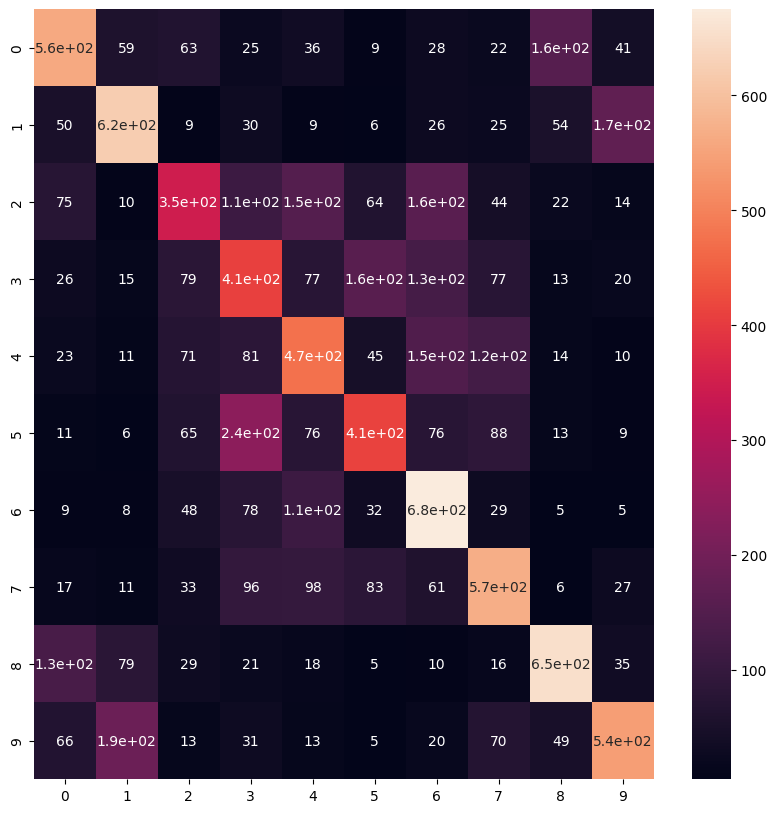

In [25]:
eval_architecture(mnist_pretrained_model, history)